In [1]:
%pwd

u'/home/ubuntu/aws-ec2'

In [2]:
import os, sys
current_dir = os.getcwd()
#HOME = os.path.join('c:/','Users','Aravindh')
HOME = '/home/ubuntu'
DATA_HOME_DIR= os.path.join(HOME,'data','redux')
sys.path.append(os.path.expanduser(os.path.join(current_dir,'utils')))

In [3]:
from Vgg import *
from utils import *

import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Action Plan

1. Create Validation and Sample sets
2. Rearrange image files into their respective directories
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

### Create validation and sample sets

In [37]:
# create directories
os.chdir(DATA_HOME_DIR)
if not os.path.exists('valid'): os.makedirs('valid')
if not os.path.exists('results'): os.makedirs('results')
if not os.path.exists(os.path.join('sample','train')): os.makedirs(os.path.join('sample','train'))
if not os.path.exists(os.path.join('sample','test')): os.makedirs(os.path.join('sample','test'))
if not os.path.exists(os.path.join('sample','valid')): os.makedirs(os.path.join('sample','valid'))
if not os.path.exists(os.path.join('sample','results')): os.makedirs(os.path.join('sample','results'))

In [57]:
# move a subset of the train data to validation directory
os.chdir(os.path.join(DATA_HOME_DIR,'train'))
g = glob('*.jpg')
shuf = np.random.permutation(g) # create a random permutation of cats and dogs
for i in range(2000): os.rename(shuf[i],os.path.join(DATA_HOME_DIR,'valid',shuf[i]))

In [58]:
# create a sample training set
os.chdir(os.path.join(DATA_HOME_DIR,'train'))
g = glob('*.jpg')
shuf = np.random.permutation(g) # create a random permutation of cats and dogs
for i in range(200): os.rename(shuf[i],os.path.join(DATA_HOME_DIR,'sample','train',shuf[i]))

In [59]:
# create a sample vaidation set
os.chdir(os.path.join(DATA_HOME_DIR,'train'))
g = glob('*.jpg')
shuf = np.random.permutation(g) # create a random permutation of cats and dogs
for i in range(50): os.rename(shuf[i],os.path.join(DATA_HOME_DIR,'sample','valid',shuf[i]))

### Rearrange image files in to their respective directories

In [62]:
# sample/train
os.chdir(os.path.join(DATA_HOME_DIR,'sample','train'))
if not os.path.exists('cats'): os.makedirs('cats')
if not os.path.exists('dogs'): os.makedirs('dogs')
for img in glob('cat*.jpg'): os.rename(img,os.path.join('cats',img))
for img in glob('dog*.jpg'): os.rename(img,os.path.join('dogs',img))

In [63]:
# sample/valid
os.chdir(os.path.join(DATA_HOME_DIR,'sample','valid'))
if not os.path.exists('cats'): os.makedirs('cats')
if not os.path.exists('dogs'): os.makedirs('dogs')
for img in glob('cat*.jpg'): os.rename(img,os.path.join('cats',img))
for img in glob('dog*.jpg'): os.rename(img,os.path.join('dogs',img))

In [64]:
# valid
os.chdir(os.path.join(DATA_HOME_DIR,'valid'))
if not os.path.exists('cats'): os.makedirs('cats')
if not os.path.exists('dogs'): os.makedirs('dogs')
for img in glob('cat*.jpg'): os.rename(img,os.path.join('cats',img))
for img in glob('dog*.jpg'): os.rename(img,os.path.join('dogs',img))

In [65]:
# train
os.chdir(os.path.join(DATA_HOME_DIR,'train'))
if not os.path.exists('cats'): os.makedirs('cats')
if not os.path.exists('dogs'): os.makedirs('dogs')
for img in glob('cat*.jpg'): os.rename(img,os.path.join('cats',img))
for img in glob('dog*.jpg'): os.rename(img,os.path.join('dogs',img))

### Finetuning and training

In [4]:
#path = DATA_HOME_DIR + '/sample'
path = os.path.join(DATA_HOME_DIR)
test_path = os.path.join(DATA_HOME_DIR,'test') #We use all the test data
results_path = os.path.join(path,'results')
train_path = os.path.join(path,'train')
valid_path = os.path.join(path,'valid')

In [5]:
# create model, load weights
vgg = Vgg()
vgg.load_weights(os.path.join(HOME,'models','vgg16.h5'))
vgg.load_imagenet_class_index(os.path.join(HOME,'models','imagenet_class_index.json'))

Hello from Vgg()


In [6]:
# Set batches and epocs
batch_size = 64
number_of_epochs = 3

In [7]:
# get and preprocess training images
train_batches = vgg.get_batches(train_path,batch_size=batch_size)
val_batches = vgg.get_batches(valid_path,batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
# fine tune model to output two classes instead to vgg's 1000
vgg.finetune(train_batches.nb_class)

In [ ]:
# Train model
for epoch in range(number_of_epochs): 
    vgg.fit(train_batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(os.path.join(results_path,latest_weights_filename))

Epoch 1/1
23000/23000 [==============================] - 608s - loss: 0.1753 - acc: 0.9558 - val_loss: 0.0947 - val_acc: 0.9715
Epoch 1/1
23000/23000 [==============================] - 608s - loss: 0.1643 - acc: 0.9579 - val_loss: 0.0988 - val_acc: 0.9665


### Generate Predictions
Use the new model to make predictions on the test data set

In [ ]:
batches, preds = vgg.predict(test_path,batch_size=batch_size*2)

In [14]:
print preds[:5]
print batches.filenames[:5]

[[  1.15227688e-03   9.98847723e-01]
 [  1.00000000e+00   1.59667150e-17]
 [  9.69945788e-01   3.00542377e-02]
 [  9.88574153e-12   1.00000000e+00]
 [  4.94927932e-10   1.00000000e+00]]
['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg', 'unknown/10000.jpg']


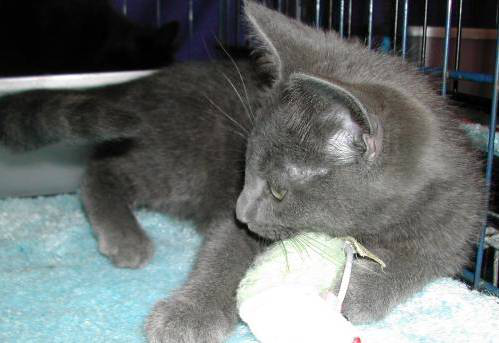

In [19]:
from PIL import Image
Image.open(os.path.join(test_path,batches.filenames[2]))

## Validate Predictions

In [9]:
# load latest weights file
vgg.model.load_weights(os.path.join(results_path,'ft2.h5'))

In [10]:
# Calculate predictions on the validation set
val_batches, probs = vgg.predict(valid_path,batch_size=batch_size)

Found 2000 images belonging to 2 classes.


In [11]:
filenames = val_batches.filenames
expected_labels = val_batches.classes # 0 or 1

# Round predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [12]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

In [14]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = np.random.permutation(correct)[:n_view]
plots_idx(idx)

Found 1931 correct labels


NameError: global name 'plots' is not defined